# 实验二 计算智能实验——基于遗传算法的机器人路径规划

## 姓名

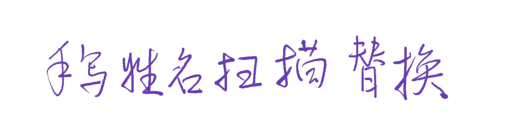

In [1]:
import skimage; import matplotlib.pyplot as plt
%matplotlib inline
name_img=skimage.io.imread(r'姓名.jpg'); plt.imshow(name_img); _=plt.axis('off')

## 学号

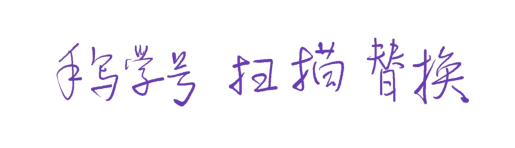

In [2]:
no_img=skimage.io.imread(r'学号.jpg');plt.imshow(no_img); _=plt.axis('off')

## 班级

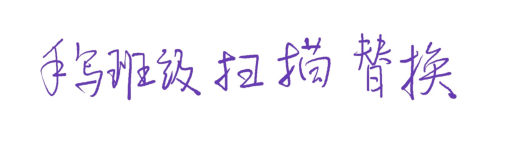

In [3]:
class_img=skimage.io.imread(r'班级.jpg');plt.imshow(class_img); _=plt.axis('off')

## 一、实验目的

- 深入理解遗传算法、粒子群算法、模糊控制算法的基本原理、操作步骤及参数设置对算法性能的影响。
  
- 掌握遗传算法在路径规划问题中的应用方法，包括染色体编码、适应度函数设计等。
  
- 分析遗传算法与传统路径规划算法在路径质量、搜索效率、适应性等方面的特点和差异。
  
- 提高运用计算智能方法解决实际问题的能力，培养编程实现能力以及对算法结果的分析与评估能力。

## 二、实验原理

### 1. 栅格地图
在栅格地图中进行机器人轨迹规划，旨在为机器人从起点 $ S $ 到终点 $ E $ 寻找一条最优或近似最优路径。栅格地图将环境划分为 $ M \times N $ 的二维网格，每个网格点代表一个位置，其状态可为无障碍（记为 $ 0 $）或有障碍（记为 $ 1 $）。机器人在地图上的移动通常被限制为只能往相邻的上下左右四个方向或八个方向移动。

### 2. 遗传算法基本原理
遗传算法（Genetic Algorithm, GA）是一种基于自然选择和遗传机制的全局优化搜索算法。其基本思想是将问题的解决方案表示为“染色体”，通过模拟生物进化过程中的选择、交叉和变异操作，使种群不断进化，以适应环境（即优化目标函数），最终获得最优或近似最优解。

### 3. 遗传算法在轨迹规划中的应用

 **（1）染色体编码**

染色体编码是将机器人轨迹的可能路径表示为遗传算法可处理的形式。在栅格地图中，可采用路径坐标序列编码，将一条路径表示为一系列栅格点坐标的有序集合，如：
$$
\text{Path} = \left\{ (x_1, y_1), (x_2, y_2), \dots, (x_k, y_k) \right\}
$$
其中， $ (x_1, y_1) $ 为起点 $ S $ ， $ (x_k, y_k) $ 为终点 $ E $ ，中间的坐标点依次表示机器人移动的路径。也可采用二进制编码，将每个栅格点的访问与否用二进制位表示，但路径坐标序列编码更直观且易于处理路径的连续性约束。

**（2）适应度函数**
适应度函数用于衡量一条路径的优劣，是遗传算法优化的核心依据。常见的适应度指标包括：

- **路径长度**：路径长度越短越好，可定义适应度函数为路径长度的倒数，即：
$$
f(\text{Path}) = \frac{1}{\text{Length}(\text{Path})}
$$
其中， $ \text{Length}(\text{Path}) $ 为路径包含的栅格点数减 $ 1 $（相邻两个栅格点之间的移动距离为 $ 1 $）。

- **路径平滑度**：平滑的路径更有利于机器人运动控制。可计算相邻两个移动方向之间的角度变化总和，角度变化越小，路径越平滑。适应度函数可定义为路径平滑度的正向度量，如：
$$
f_{\text{smooth}}(\text{Path}) = - \sum_{i=1}^{k-2} \theta_i
$$
其中， $ \theta_i $ 为第 $ i $ 段移动方向与第 $ i+1 $ 段移动方向之间的夹角，取值范围为 $ [0, 2\pi) $，并取负号使其与平滑度正相关。

- **综合适应度函数**：为了同时考虑路径长度和路径平滑度等因素，可构造综合适应度函数：
$$
f_{\text{total}}(\text{Path}) = \alpha \cdot f(\text{Path}) + \beta \cdot f_{\text{smooth}}(\text{Path})
$$
其中， $ \alpha $ 和 $ \beta $ 为权重系数，用于平衡路径长度和平滑度在适应度评估中的相对重要性。在实际应用中，可根据具体的轨迹规划要求调整权重值，例如在对路径长度要求较高的应用场景中，可适当增大 $ \alpha $ 的值。

此外，对于不可行路径（即经过障碍物的路径），需给予较低的适应度或直接淘汰。在计算适应度之前，先检查路径中的每个栅格点是否为障碍物，若存在障碍物，则适应度值设为一个极小值（如 $ 0 $ 或负无穷），以确保这些不可行路径在进化过程中被淘汰。

**（3）初始化种群**
随机生成一定数量的初始路径作为初始种群。生成路径时需确保路径的起点为 $ S $ ，终点为 $ E $，且路径中的中间点不超出地图边界。可通过随机游走的方式生成初始路径：从起点出发，每次随机选择一个可行的移动方向（不撞墙且未被访问过的相邻栅格点），直到到达终点或达到最大步数限制。若未到达终点，则丢弃该路径并重新生成。为保证种群多样性，可采用多种生成策略或调整生成参数。

**（4）选择操作**
选择操作用于从当前种群中选择适应度较高的个体作为父代，参与后续的交叉和变异操作。常用的选择方法包括：

- **轮盘赌选择**：个体被选中的概率与其适应度成正比。计算种群中每个个体的选择概率 $ p_i $：
$$
p_i = \frac{f(\text{Path}_i)}{\sum_{j=1}^N f(\text{Path}_j)}
$$
其中， $ N $ 为种群规模。再根据选择概率随机选择个体。但该方法存在“早熟收敛”问题，即适应度高的个体可能过早占据主导，导致种群多样性丧失。

- **锦标赛选择**：随机选取 $ k $ 个个体进行比较，选择适应度最高的个体作为父代。这种方法简单且能有效避免早熟收敛问题。例如，当 $ k = 2 $ 时，每次随机选两个个体，适应度高的那个胜出。

**（5）交叉操作**
交叉操作模拟生物遗传中的基因重组，通过交换两个父代个体的部分路径片段生成新的子代个体。常见的交叉方法有：

-  **单点交叉**：随机选择一个交叉点，将两个父代路径在该点处的路径片段进行交换。例如，父代路径 $ P1 = \{A, B, C, D, E\} $ 和 $ P2 = \{A, F, G, D, E\} $，在位置 $ 3 $ 处交叉，生成子代 $ C1 = \{A, B, G, D, E\} $ 和 $ C2 = \{A, F, C, D, E\} $。但需注意交叉后生成的路径仍需满足可行性（不穿过障碍物）。

- **多点交叉**：选择多个交叉点进行路径片段交换，增加路径的多样性。

- **部分映射交叉（Partially Mapped Crossover, PMX）**：适用于路径编码的交叉方法。先随机选择两个交叉点，将父代路径在交叉点之间的片段直接交换，然后对交叉点外的路径部分进行调整，确保子代路径的完整性和可行性。例如，父代路径 $ P1 = \{1, 2, 3, 4, 5, 6\} $ 和 $ P2 = \{6, 5, 4, 3, 2, 1\} $，交叉点选在位置 $ 2 $ 和 $ 4 $ 之间。交换中间片段后得到临时子代 $ C1' = \{1, 5, 4, 3, 5, 6\} $ 和 $ C2' = \{6, 2, 3, 4, 2, 1\} $，然后对交叉点外的重复元素进行映射处理，最终得到合法子代 $ C1 = \{1, 5, 4, 3, 2, 6\} $ 和 $ C2 = \{6, 2, 3, 4, 5, 1\} $。

**（6）变异操作**
变异操作以一定概率改变个体的部分基因，增加种群的多样性，防止算法陷入局部最优。常见的变异方法包括：

- **基本位变异**：随机改变路径中的某个栅格点坐标。但需确保变异后的坐标在地图边界内且不为障碍物。例如，选择路径中的一个点 $ (x, y) $，将其变为 $ (x + \Delta x, y + \Delta y) $，其中 $ \Delta x $ 和 $ \Delta y $ 为随机生成的小范围整数变化量。

- **交换变异**：随机选择路径中的两个相邻栅格点，交换它们的顺序。这有助于改变路径的局部走向，增加路径的多样性。

- **插入变异**：在路径中随机插入一个新的栅格点，或删除一个冗余的栅格点。插入操作可探索更长路径的可能性，删除操作则有助于简化路径。

**（7）算法终止条件**
设定遗传算法的终止条件，以控制算法的运行时间和计算资源消耗。常见的终止条件包括：

- **达到最大迭代次数**：预先设定一个最大迭代次数 $ T_{\text{max}} $，当算法迭代达到该次数时停止。

- **找到满意解**：当种群中出现适应度满足要求的个体（如路径长度小于等于某个阈值），则认为找到满意解并终止算法。

- **适应度变化趋于稳定**：若在连续若干代的进化过程中，种群的最大适应度值变化小于某个阈值，则认为算法已收敛，终止进化。

### 4. 算法流程总结
1. 初始化：根据栅格地图、起点和终点信息，生成初始种群。
2. 适应度评估：计算种群中每个个体的适应度值。
3. 选择：根据适应度值选择父代个体。
4. 交叉和变异：对父代个体进行交叉和变异操作，生成子代个体。
5. 更新种群：将子代个体替换部分或全部父代个体，形成新一代种群。
6. 检查终止条件：若满足终止条件，则输出最优路径；否则，返回步骤 2 继续迭代。



## 三、实验内容与步骤

### 1. 环境搭建

本次实验中使用的环境模型是横向、纵向各有20个小格的栅格地图。在该环境模型中，机器人的路径规划问题可以概括为以下几步：

(1) 从设定的起始点抵达设定的终点。

(2) 机器人在移动过程中不能碰撞障碍物，否则失败。

(3) 在满足以上条件的情况下，要使得机器人的行动路线尽可能地符合规划路径短的评价指标条件。

将机器人作为一个极小的质点，并按照实际的尺寸比例来模拟障碍物大小，将其投影到栅格子中。把障碍物映射到的环境格子设置成黑色格子，绿色格子为安全区域。这里将障碍物映射到的格子，无论其在格子中的占比有多少，都统一将其整个格子涂黑，作为障碍物的映射区域。机器人通过在安全区域(即：绿色格子)上点到点的移动，连接成规划路径。

In [4]:
#如果你的环境中没有pygame，那么需要用底下的指令安装pygame
#!pip install pygame

In [5]:
# 定义全局变量
import globalVar
globalVar._init()
globalVar.set_value('CELL_WIDTH', 16) #单元格宽度
globalVar.set_value('CELL_HEIGHT',16) #单元格长度
globalVar.set_value('BORDER_WIDTH', 1) #边框宽度
globalVar.set_value('BLOCK_NUM', 70) #地图中的障碍物数量
globalVar.set_value('TEST_NUM', 15) #实验测试次数

In [6]:
import matplotlib.pyplot as plt
import skimage
from aboutMap import Color, Map, generate_random_obstacles
from aboutResults import showResults, saveResultImg
import numpy as np
import random
import math

pygame 2.6.1 (SDL 2.28.4, Python 3.9.21)
Hello from the pygame community. https://www.pygame.org/contribute.html


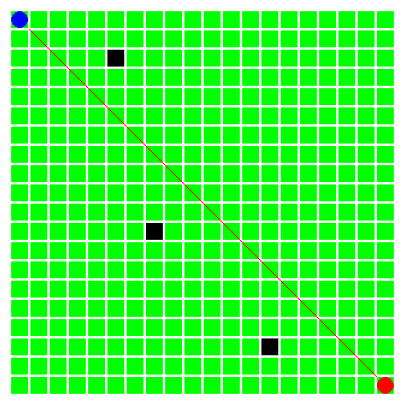

In [7]:
# 构建地图
# 使用tuple和map函数创建一个20×20的栅格地图
# map函数将(20,20)中的每个元素转换为整数，然后用tuple将结果转换为元组
mapsize = tuple(map(int, (20,20)))  #产生一个20×20的栅格地图

# 设置起点坐标(0,0)，即地图左上角
# 同样使用tuple和map函数将坐标转换为整数元组
pos_snode = tuple(map(int, (0,0)))  #设置机器人运动的起点为地图中左上角

# 设置终点坐标(19,19)，即地图右下角
pos_enode = tuple(map(int, (19,19))) #设置机器人运动的终点为地图的右下角

# 定义障碍物列表，每个元素为障碍物的坐标点
# 在地图中会用黑色方块表示这些障碍物
blocklist=[(5,2), (7,11), (13, 17)]

# 定义机器人可以经过的路径点列表
# 这些点将在地图上用红色线连接，表示机器人的运动轨迹
# 当前路径是一条从(1,1)到(19,19)的对角线
routelist=[(1,1), (2,2), (3,3), (4,4),(5,5),(6,6), (7,7), (8,8), (9,9), (10,10),
           (11,11),(12,12), (13,13),(14,14),(15,15),(16,16),(17,17),(18,18),(19,19)]

# 调用saveResultImg函数将地图保存为图片
# 函数参数包括：地图大小、起点、终点、障碍物列表和路径列表
saveResultImg(mapsize, pos_snode, pos_enode, blocklist, routelist)

# 创建一个5x5英寸的图形窗口
plt.figure(figsize=(5,5))

# 使用skimage库读取生成的地图图片
img1= skimage.io.imread('result0.png')

# 显示图片
plt.imshow(img1)

# 关闭坐标轴显示
plt.axis('off')

# 展示图片
plt.show()

### 2. 基于A*搜索的路径规划

Node类是A*路径规划算法中的核心数据结构，用于表示搜索空间中的节点。每个节点包含位置信息、代价估计以及父节点引用，用于构建最终的路径。

![Node类](node说明.png)

**属性说明**
- position
   
   - 类型：tuple(x, y)
   - 功能：存储节点在二维空间中的坐标位置
   - 用途：用于定位节点在地图中的具体位置
- g_cost
   
   - 类型：float
   - 功能：记录从起点到当前节点的实际代价
   - 默认值：float('inf')（无穷大）
   - 用途：用于计算路径的实际代价
- h_cost
   
   - 类型：float
   - 功能：存储从当前节点到目标点的估计代价
   - 默认值：0
   - 用途：启发式函数值，用于指导搜索方向
- parent
   
   - 类型：Node
   - 功能：指向生成当前节点的父节点
   - 默认值：None
   - 用途：用于在找到目标后回溯构建完整路径

**方法说明**

- init (position, g_cost=float('inf'), h_cost=0)
   
   - 功能：初始化节点对象
   - 参数：
     - position：节点位置坐标
     - g_cost：实际代价（可选）
     - h_cost：估计代价（可选）
   - 行为：初始化所有属性，设置父节点为None
- f_cost()
   
   - 功能：计算节点的总代价
   - 返回值：f = g + h（实际代价 + 估计代价）
   - 用途：用于A*算法中的节点优先级排序
- lt (other)
   
   - 功能：重载小于运算符
   - 参数：other - 另一个Node对象
   - 返回值：布尔值，表示当前节点的f值是否小于other节点
   - 用途：支持优先队列中的节点排序
  
**使用场景说明**

- 路径搜索 ：在A*算法中作为基本数据单元
- 代价计算 ：通过f_cost()方法计算节点的评估值
- 路径回溯 ：利用parent属性构建最终路径
- 优先级排序 ：在开放列表中进行节点排序

In [8]:
class Node:
    """
    节点类：用于搜索算法中表示路径规划的节点
    属性:
        position: 节点在地图中的位置坐标
        g_cost: 从起点到当前节点的实际代价
        h_cost: 从当前节点到目标点的估计代价（启发式值）
        parent: 父节点，用于回溯最终路径
    """
    def __init__(self, position, g_cost=float('inf'), h_cost=0):
        """
        初始化节点
        参数:
            position: 节点位置坐标
            g_cost: 从起点到该节点的代价，默认为无穷大
            h_cost: 预估的到终点的代价，默认为0
        """
        self.position = position    # 存储节点的位置坐标
        self.g_cost = g_cost       # 从起点到当前节点的实际代价
        self.h_cost = h_cost       # 从当前节点到目标的估计代价
        self.parent = None         # 父节点，初始化为None
        
    def f_cost(self):
        """
        计算节点的f值
        返回:
            f值 = g值（实际代价）+ h值（估计代价）
        """
        return self.g_cost + self.h_cost
    
    def __lt__(self, other):
        """
        重载小于运算符，用于优先队列的比较
        参数:
            other: 另一个Node对象
        返回:
            当前节点的f值是否小于另一个节点的f值
        """
        return self.f_cost() < other.f_cost()




          
在A*路径规划算法中，启发式函数（heuristic function）是决定算法性能的关键组件。这段代码实现了一个基于曼哈顿距离（Manhattan distance）的启发式函数，用于估计从当前节点到目标节点的代价。

**函数原理**

曼哈顿距离是在二维网格中从一点到另一点的最短路径长度，其计算方式为两点在x轴和y轴上的距离差的绝对值之和。对于给定的起点$(x_1, y_1)$和终点$(x_2, y_2)$，曼哈顿距离的计算公式为：

$$h(n) = |x_1 - x_2| + |y_1 - y_2|$$

这种距离计算方法特别适合在网格化地图中使用，因为它反映了在只能水平和垂直移动的情况下的最短路径长度。

**函数特性**

- **可接受性（Admissible）**：
   曼哈顿距离具有可接受性，即它永远不会高估实际代价。这是因为实际路径必须至少走过x方向和y方向的距离差。

- **一致性（Consistent）**：
   该启发式函数满足三角不等式，确保了估计值的一致性，这有助于A*算法找到最优路径。

- **计算效率**：
   仅需要简单的加法和减法运算，计算开销小，适合实时路径规划。

**实现说明**

函数接收两个参数：起点坐标`start`和目标坐标`goal`，每个坐标都是一个二元组`(x, y)`。函数通过分别计算x轴和y轴上的距离差，然后求和得到最终的启发式估计值。这种实现方式简洁高效，易于理解和维护。

        

In [9]:
def heuristic(start, goal):
    """
    计算从起点到终点的启发式值（预估代价）
    使用曼哈顿距离（Manhattan distance）作为启发式函数
    
    参数:
        start: 起始节点的坐标，格式为(x, y)
        goal: 目标节点的坐标，格式为(x, y)
        
    返回:
        float: 从start到goal的预估代价
    """
    # 计算x方向上的距离差
    dx = abs(start[0] - goal[0])
    # 计算y方向上的距离差
    dy = abs(start[1] - goal[1])
    # 返回曼哈顿距离
    return dx + dy




          
A*算法是一种启发式搜索算法，通过结合实际代价和预估代价来寻找最优路径。该实现针对二维网格地图进行了优化，支持障碍物避让和最短路径搜索。

**数据结构设计**
数据结构设计见下图：

![数据结构设计](数据结构设计.png)

其中，核心组件包括：

**搜索空间管理**：
- 开放列表（open_list）：存储待探索的节点
- 关闭集合（closed_set）：记录已访问的位置
- 节点字典（node_dict）：快速访问和更新节点信息
- 移动方向：定义四个基本方向 $(上,右,下,左)$

**代价函数设计**：

路径代价由两部分组成：
- 实际代价 $g(n)$：从起点到当前节点的实际移动代价
- 启发式代价 $h(n)$：从当前节点到目标的估计代价

总代价 $f(n)$：$f(n) = g(n) + h(n)$

**A*算法的路径搜索流程**：
(1) **初始化**：
   - 创建起始节点
   - 将起始节点加入开放列表
   - 初始化节点字典

(2) **主循环**：

![A*算法的路径搜索流程](主循环流程图.png)

(3) **节点扩展**：
   - 检查四个方向的相邻位置
   - 验证位置有效性（地图边界和障碍物）
   - 计算新节点的代价
   - 更新更优路径

(4) **路径回溯**：
当找到目标节点时，通过父节点引用构建完整路径：
$$path = [node_n, node_{n-1}, ..., node_1, node_0]$$

**A*算法的实现特点**
- **高效的节点管理**：
   - 使用字典实现O(1)的节点查找
   - 集合结构快速判断节点状态

- **完备性保证**：
   - 若存在路径，必定能找到
   - 通过关闭集合避免重复访问

- **最优性保证**：
   - 采用一致的启发式函数
   - 保证找到的路径是最优的

- **灵活的地图表示**：
   - 支持自定义地图大小
   - 灵活的障碍物配置

**目前实现的使用限制**：
- 仅支持四方向移动
- 地图为离散网格表示
- 障碍物为点状表示
- 移动代价均为单位值1

        

In [10]:
def astar(start, goal, obstacles, mapsize=(20, 20)):
    """
    A*搜索算法实现
    
    参数:
        start: 起始位置坐标 (x, y)
        goal: 目标位置坐标 (x, y)
        obstacles: 障碍物位置列表
        mapsize: 地图大小 (width, height)
        
    返回:
        path: 找到的路径列表，如果没找到则返回None
    """
    # 定义移动方向：上、右、下、左
    directions = [(0, -1), (1, 0), (0, 1), (-1, 0)]
    
    # 创建开放列表和关闭列表
    open_list = []
    closed_set = set()
    
    # 创建起始节点
    start_node = Node(start, 0, heuristic(start, goal))
    open_list.append(start_node)
    
    # 用字典存储每个位置对应的节点
    node_dict = {start: start_node}
    
    def is_valid(pos):
        """检查位置是否有效"""
        x, y = pos
        return (0 <= x < mapsize[0] and 
                0 <= y < mapsize[1] and 
                pos not in obstacles)
    
    while open_list:
        # 获取f值最小的节点
        current_node = min(open_list)
        current_pos = current_node.position
        
        # 如果到达目标，构建并返回路径
        if current_pos == goal:
            path = []
            while current_node:
                path.append(current_node.position)
                current_node = current_node.parent
            return path[::-1]  # 反转路径，从起点到终点
        
        # 将当前节点从开放列表移到关闭列表
        open_list.remove(current_node)
        closed_set.add(current_pos)
        
        # 检查所有相邻节点
        for dx, dy in directions:
            next_pos = (current_pos[0] + dx, current_pos[1] + dy)
            
            # 检查位置是否有效且未被访问
            if not is_valid(next_pos) or next_pos in closed_set:
                continue
            
            # 计算从起点经过当前节点到相邻节点的代价
            g_cost = current_node.g_cost + 1
            
            # 如果是新节点或找到更好的路径
            if next_pos not in node_dict or g_cost < node_dict[next_pos].g_cost:
                # 创建新节点或更新现有节点
                h_cost = heuristic(next_pos, goal)
                neighbor = Node(next_pos, g_cost, h_cost)
                neighbor.parent = current_node
                node_dict[next_pos] = neighbor
                
                # 如果节点不在开放列表中，添加它
                if neighbor not in open_list:
                    open_list.append(neighbor)
    
    # 如果没有找到路径，返回None
    return None


A*路径规划算法的实际应用过程主要包含路径规划的执行和结果可视化两个部分。
在路径规划执行部分，代码通过`generate_random_obstacles`函数在地图上随机生成50个障碍物，同时确保障碍物不会出现在起点`pos_snode`和终点`pos_enode`的位置。这些障碍物将作为路径规划时需要避开的区域。

接着，代码调用之前实现的`astar`函数进行路径规划。该函数接收起点、终点和障碍物信息作为输入参数，返回规划得到的路径。如果成功找到路径，程序会将路径信息保存在`routelist_Astar`变量中；如果未能找到有效路径（比如起点和终点之间被障碍物完全阻隔），则将返回一个空列表。

在结果可视化部分，代码通过`saveResultImg`函数将规划结果保存为图片文件（'result0.png'）。这个函数会在地图上标注起点、终点、障碍物和规划路径。然后使用matplotlib库创建了一个8×8大小的图形窗口，通过`skimage.io.imread`函数读取保存的结果图片，并使用`imshow`函数显示。为了使显示效果更加清晰，代码隐藏了坐标轴（`axis('off')`），并添加了标题"A* Path Planning Result"。
        

Path found!


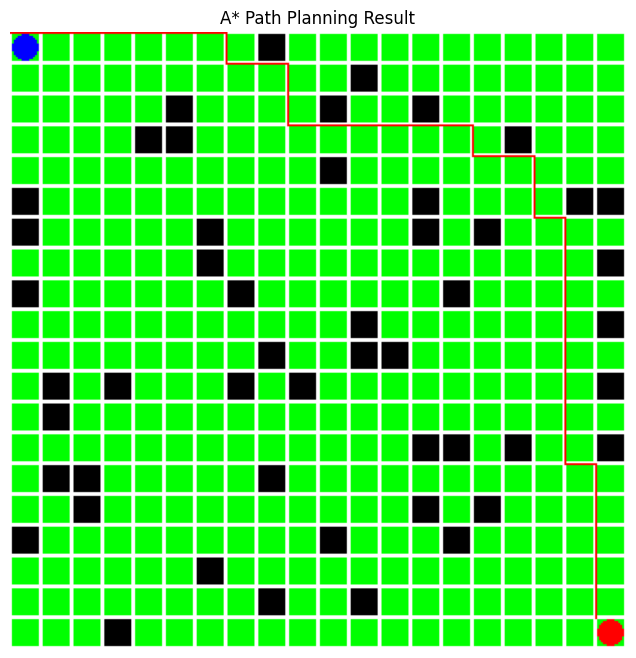

In [11]:
# 生成70个随机障碍物
obstacles = generate_random_obstacles(mapsize, 50, pos_snode, pos_enode)

# 使用A*算法寻找路径
path = astar(pos_snode, pos_enode,obstacles)

if path:
    print("Path found!")
    # 将路径转换为routelist格式
    routelist_Astar = path
else:
    print("No valid path found!")
    routelist_Astar = []

# 保存并显示结果
saveResultImg(mapsize, pos_snode, pos_enode, obstacles, routelist_Astar)

# 显示结果图
plt.figure(figsize=(8, 8))
img = skimage.io.imread('result0.png')
plt.imshow(img)
plt.axis('off')
plt.title('A* Path Planning Result')
plt.show()

### 3. 基于遗传算法的机器人路径规划

使用遗传算法来解决机器人路径规划问题。通过模拟生物进化过程，在给定起点和终点的情况下，寻找一条避开障碍物的最优路径。

- 路径由一系列二维坐标点组成：$(x_1,y_1), (x_2,y_2), ..., (x_n,y_n)$
- 起点和终点固定，中间点通过算法优化

**适应度函数**包含以下几个部分：

  - 路径长度 ：
   $$length = \sum_{i=1}^{n-1} \sqrt{(x_{i+1}-x_i)^2 + (y_{i+1}-y_i)^2}$$
  - 障碍物避让 ：
   对于路径上的每条线段，计算障碍物到线段的距离：
   $$d_{obstacle} = \frac{|ax_0 + by_0 + c|}{\sqrt{a^2 + b^2}}$$
   其中$(x_0,y_0)$为障碍物坐标，$(ax+by+c=0)$为路径线段所在直线方程
  - 平滑度约束 ：
   相邻路径点之间的距离不应过大，使用惩罚项：
   $$penalty_{smooth} = 500 \times (d_{segment} - 1), \text{ if } d_{segment} > 1$$

**遗传操作**包括：
- 选择操作：
   
   - 采用锦标赛选择
   - 每次从种群中随机选择3个个体
   - 选择适应度最好的个体进入下一代

- 交叉操作：
   
   - 单点交叉
   - 随机选择交叉点
   - 交换父代在交叉点后的基因片段

- 变异操作 ：
   
   - 概率为0.2的随机变异
   - 随机选择路径点进行小范围调整
   - 变异范围限制在[-1, 1]之内

**算法参数**设定如下：
- 种群大小：100
- 迭代代数：200
- 变异率：0.2
- 障碍物安全距离：1.0
- 路径平滑度阈值：1.0
- 障碍物惩罚系数：1000
- 平滑度惩罚系数：500
- 目标未达成惩罚：2000
  
**设计适应度函数时考虑的约束条件**如下：
- 路径必须在地图边界内
- 路径必须避开障碍物（保持1个单位的安全距离）
- 相邻路径点间距不应过大（保持平滑性）
- 路径必须从起点到达终点
  
**遗传算法的优化目标**
最小化总成本函数：
$$Cost = length + penalty_{obstacles} + penalty_{smooth} + penalty_{goal}$$

其中各项分别代表路径长度、障碍物避让惩罚、平滑度惩罚和目标达成惩罚。

In [12]:
class GeneticPathPlanner:
    def __init__(self, map_size=(20, 20), obstacles=None, population_size=100, generations=200):
        """
        初始化路径规划器
        Args:
            map_size: 地图大小，默认为20x20
            obstacles: 障碍物列表，每个障碍物为(x,y)坐标
            population_size: 种群大小，默认150
            generations: 迭代代数，默认200
        """
        self.map_size = map_size
        self.obstacles = obstacles if obstacles else []
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = 0.2  # 变异概率
        
    def generate_initial_population(self, start, goal):
        """
        生成初始种群
        Args:
            start: 起点坐标(x,y)
            goal: 终点坐标(x,y)
        Returns:
            population: 路径列表，每个路径是一系列坐标点
        """
        population = []
        # 估计路径长度：起终点直线距离的2倍
        path_length = int(np.sqrt((goal[0]-start[0])**2 + (goal[1]-start[1])**2)) * 5
        
        for _ in range(self.population_size):
            path = [start]
            current = start
            # 随机生成路径点
            for _ in range(path_length):
                dx = random.randint(-1, 1)  # 在x方向随机移动[-1,1]
                dy = random.randint(-1, 1)  # 在y方向随机移动[-1,1]
                # 确保新点在地图范围内
                next_point = (
                    min(max(current[0] + dx, 0), self.map_size[0]-1),
                    min(max(current[1] + dy, 0), self.map_size[1]-1)
                )
                path.append(next_point)
                current = next_point
            path.append(goal)
            population.append(path)
        return population

    def fitness(self, path, goal):
        """
        计算路径的适应度值（越小越好）
        Args:
            path: 路径点列表
            goal: 终点坐标
        Returns:
            float: 适应度值（路径长度 + 惩罚项）
        """
        penalty = 0
        
        # 检查每个路径段
        for i in range(len(path)-1):          
            # 计算路径段所在直线方程 ax + by + c = 0
            x1, y1 = path[i]
            x2, y2 = path[i+1]
            
            a = y2 - y1  # 直线参数a
            b = x1 - x2  # 直线参数b
            c = x2*y1 - x1*y2  # 直线参数c
            
            # 计算路径段长度
            line_length = np.sqrt(a*a + b*b)

            if line_length == 0:
                continue  # 跳过长度为0的路径段
            
            # 平滑度惩罚：相邻点距离不应过大
            if line_length > 1:
                penalty += 500 * (line_length - 1)
            
            # 检查与每个障碍物的距离
            for obstacle in self.obstacles:
                x0, y0 = obstacle
                # 计算障碍物到路径段的垂直距离
                distance_to_line = abs(a*x0 + b*y0 + c) / line_length
                
                # 如果距离小于安全距离（1个单位），添加惩罚
                if distance_to_line < 1.1:
                    penalty += 1000 * (1 - distance_to_line)
        
        # 计算总路径长度
        length = sum(np.sqrt((path[i+1][0]-path[i][0])**2 + 
                           (path[i+1][1]-path[i][1])**2) 
                    for i in range(len(path)-1))
        
        # 检查是否到达目标点
        if path[-1] != goal:
            penalty += 2000
        
        return length + penalty

    def crossover(self, parent1, parent2):
        """
        执行交叉操作
        Args:
            parent1, parent2: 父代路径
        Returns:
            list: 子代路径
        """
        if len(parent1) != len(parent2):
            return parent1
        
        # 随机选择交叉点，交换后半段基因
        crossover_point = random.randint(1, len(parent1)-2)
        child = parent1[:crossover_point] + parent2[crossover_point:]
        return child

    def mutate(self, path):
        """
        执行变异操作
        Args:
            path: 待变异的路径
        Returns:
            list: 变异后的路径
        """
        if random.random() < self.mutation_rate:
            # 随机选择一个中间点进行变异
            idx = random.randint(1, len(path)-2)
            # 在[-1,1]范围内随机调整坐标
            dx = random.randint(-1, 1)
            dy = random.randint(-1, 1)
            # 确保变异后的点在地图范围内
            path[idx] = (
                min(max(path[idx][0] + dx, 0), self.map_size[0]-1),
                min(max(path[idx][1] + dy, 0), self.map_size[1]-1)
            )
        return path

    def plan_path(self, start, goal, isShowProcess=True):
        """
        执行路径规划
        Args:
            start: 起点坐标
            goal: 终点坐标
        Returns:
            tuple: (最优路径, 适应度历史记录)
        """
        # 初始化种群
        population = self.generate_initial_population(start, goal)
        
        best_fitness = float('inf')
        best_path = None
        
        # 记录每一代的最优适应度
        fitness_history = []
        
        # 进行遗传算法迭代
        for generation in range(self.generations):
            # 计算种群中所有个体的适应度
            fitness_scores = [self.fitness(path, goal) for path in population]
            
            # 更新最优解
            min_fitness = min(fitness_scores)
            if min_fitness < best_fitness:
                best_fitness = min_fitness
                best_path = population[fitness_scores.index(min_fitness)]
            
            # 记录当前代的最优适应度
            fitness_history.append(min_fitness)
            
            # 选择操作：锦标赛选择
            selected = []
            for _ in range(self.population_size):
                tournament = random.sample(list(enumerate(fitness_scores)), 3)
                winner = min(tournament, key=lambda x: x[1])[0]
                selected.append(population[winner])
            
            # 交叉和变异操作
            new_population = []
            for i in range(0, self.population_size, 2):
                parent1 = selected[i]
                parent2 = selected[min(i+1, self.population_size-1)]
                
                child1 = self.crossover(parent1, parent2)
                child2 = self.crossover(parent2, parent1)
                
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                
                new_population.extend([child1, child2])
            
            population = new_population[:self.population_size]
            
            if generation % 10 == 0 and isShowProcess:
                print(f"Generation {generation}, Minimum Cost: {best_fitness}")
    
        
        # 如果找到可行路径，进行路径平滑和点删除处理
        if best_path:
            # 第一步：路径平滑
            smoothed_path = [best_path[0]]  # 保留起点
            for i in range(1, len(best_path)-1):
                prev = smoothed_path[-1]
                current = best_path[i]
                next_point = best_path[i+1]
                
                # 使用加权平均进行平滑
                smooth_x = 0.25 * prev[0] + 0.5 * current[0] + 0.25 * next_point[0]
                smooth_y = 0.25 * prev[1] + 0.5 * current[1] + 0.25 * next_point[1]
                smoothed_path.append((smooth_x, smooth_y))
            smoothed_path.append(best_path[-1])  # 保留终点
            
            # 第二步：删除距离过近的点和检测回环
            i = 0
            while i < len(smoothed_path)-1:
                # 检查当前点与所有后续点的距离
                current = smoothed_path[i]
                j = i + 1
                while j < len(smoothed_path):
                    next_point = smoothed_path[j]
                    dist = math.sqrt((next_point[0]-current[0])**2 + 
                                   (next_point[1]-current[1])**2)
                    
                    # 如果找到距离过近的点（可能是回环）
                    if dist < 0.5 and i != 0 and j != len(smoothed_path)-1:
                        # 检查是否形成回环
                        # 计算中间路径段的总长度
                        loop_length = sum(
                            math.sqrt(
                                (smoothed_path[k+1][0]-smoothed_path[k][0])**2 + 
                                (smoothed_path[k+1][1]-smoothed_path[k][1])**2
                            ) for k in range(i, j)
                        )
                        
                        # 如果中间路径段长度远大于直接距离，说明形成了回环
                        if loop_length > dist * 2:
                            # 删除回环上的所有点
                            del smoothed_path[i+1:j]
                            # 不增加i，因为需要重新检查当前点
                            break
                        # 如果只是距离过近的点
                        elif dist < 0.5:
                            # 删除后一个点
                            smoothed_path.pop(j)
                            # 不增加j，因为需要检查下一个点
                            continue
                    j += 1
                i += 1
            
            best_path = smoothed_path
        
        return best_path, fitness_history




          
基于遗传算法的路径规划器的使用过程包括路径规划的执行、适应度变化的可视化以及最终路径的展示。具体如下：

在路径规划执行部分，代码首先创建了一个遗传算法路径规划器实例，将地图大小和障碍物信息作为初始化参数。随后调用`plan_path`方法进行路径规划，该方法接收起点`pos_snode`和终点`pos_enode`作为参数，同时通过`isShowProcess=True`参数启用了规划过程的实时显示功能。规划器会返回找到的最优路径和每一代的适应度历史记录。

在结果处理与可视化部分，代码采用了双重可视化方案来展示规划结果：

首先是对适应度进化曲线的展示，代码创建了一个10×5大小的图形窗口，用于展示遗传算法的收敛过程。横轴表示进化代数，纵轴表示每一代的最优适应度值。通过这条曲线，我们可以直观地观察：
- 算法的收敛速度
- 是否陷入局部最优
- 最终解的质量

然后对路径规划结果进行展示，代码使用8×8大小的图形窗口展示最终的规划路径。通过`saveResultImg`函数将规划结果保存为图片，并使用`skimage.io.imread`读取显示。这张图包含了：
- 起点和终点的位置
- 障碍物的分布
- 规划得到的最优路径

整个可视化过程不仅展示了算法的最终结果，还通过适应度曲线展示了算法的优化过程，这对于理解和调优遗传算法的参数（如种群大小、变异率等）非常有帮助。如果算法成功找到路径，结果会被保存在`routelist_dfs`中；如果未找到有效路径，则返回空列表。这种完整的结果展示方式有助于我们全面评估算法的性能和效果。

        

Generation 0, Minimum Cost: 232438.619652797
Generation 10, Minimum Cost: 152263.49538998303
Generation 20, Minimum Cost: 130122.28484778672
Generation 30, Minimum Cost: 115159.04061342697
Generation 40, Minimum Cost: 104553.35415394427
Generation 50, Minimum Cost: 95569.72631175506
Generation 60, Minimum Cost: 86415.30373460456
Generation 70, Minimum Cost: 79551.76123084828
Generation 80, Minimum Cost: 73956.40653569854
Generation 90, Minimum Cost: 71654.59576611448
Generation 100, Minimum Cost: 68442.6605578032
Generation 110, Minimum Cost: 66229.24001960938
Generation 120, Minimum Cost: 62844.903508919524
Generation 130, Minimum Cost: 59875.926197352055
Generation 140, Minimum Cost: 56611.528596203905
Generation 150, Minimum Cost: 55019.44923105764
Generation 160, Minimum Cost: 53599.57881443505
Generation 170, Minimum Cost: 52097.57881443505
Generation 180, Minimum Cost: 49099.87174195441
Generation 190, Minimum Cost: 48510.620803932885
Path found!


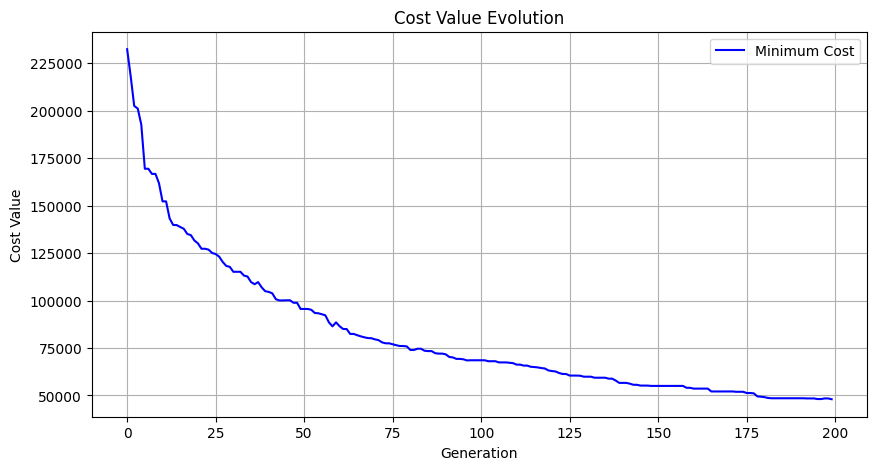

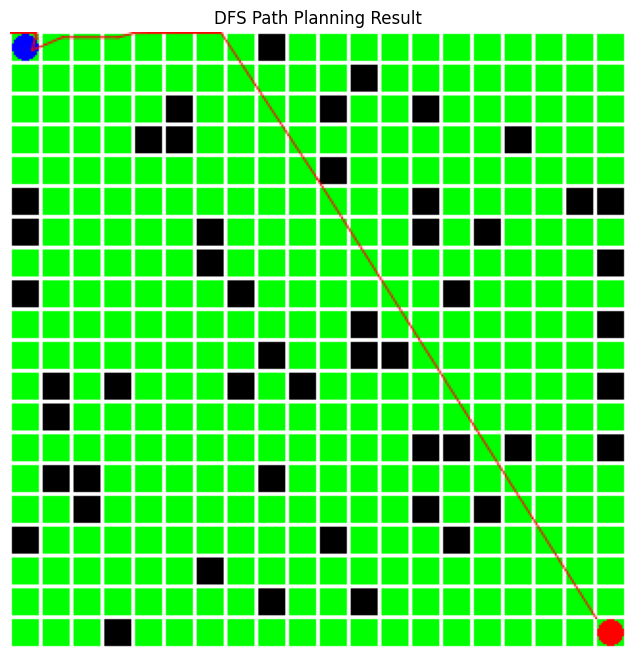

In [13]:
# 创建路径规划器
planner = GeneticPathPlanner(map_size=mapsize, obstacles=obstacles)

# 规划路径
path, fitness_history = planner.plan_path(pos_snode, pos_enode, isShowProcess=True)

if path:
    print("Path found!")
    # 将路径转换为routelist格式
    routelist_dfs = path
else:
    print("No valid path found!")
    routelist_dfs = []

# 保存并显示结果
saveResultImg(mapsize, pos_snode, pos_enode, obstacles, routelist_dfs)

# 创建新的图形窗口
plt.figure(figsize=(10, 5))

# 绘制适应度变化曲线
generations = range(len(fitness_history))
plt.plot(generations, fitness_history, 'b-', label='Minimum Cost')

# 设置图形属性
plt.xlabel('Generation')
plt.ylabel('Cost Value')
plt.title('Cost Value Evolution')
plt.grid(True)
plt.legend()

# 显示图形
plt.show()

# 显示结果图
plt.figure(figsize=(8, 8))
img = skimage.io.imread('result0.png')
plt.imshow(img)
plt.axis('off')
plt.title('DFS Path Planning Result')
plt.show()

## 四、 重复进行对比实验

重复进行5次对比实验，每次实验中，随机布置70各障碍物的位置，机器人的初始位置和目标位置不变。分别用深度优先搜索与A*算法求解路径，并将实验结果进行对比分析。


Experiment 1
Gene: Path found!
Gene path length: 21
A*: Path found!
A* path length: 39


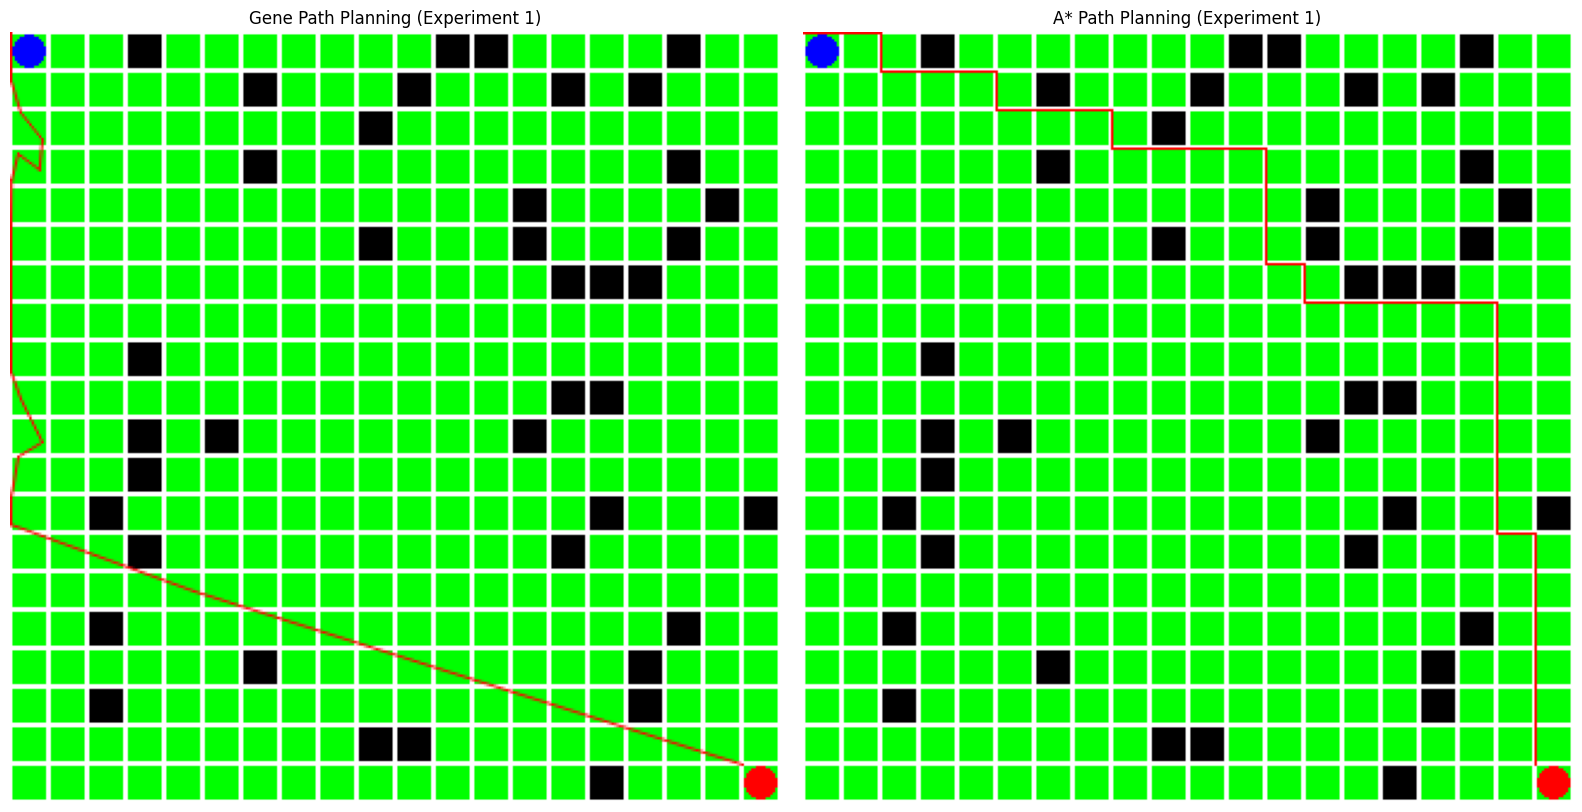


Experiment 2
Gene: Path found!
Gene path length: 8
A*: Path found!
A* path length: 39


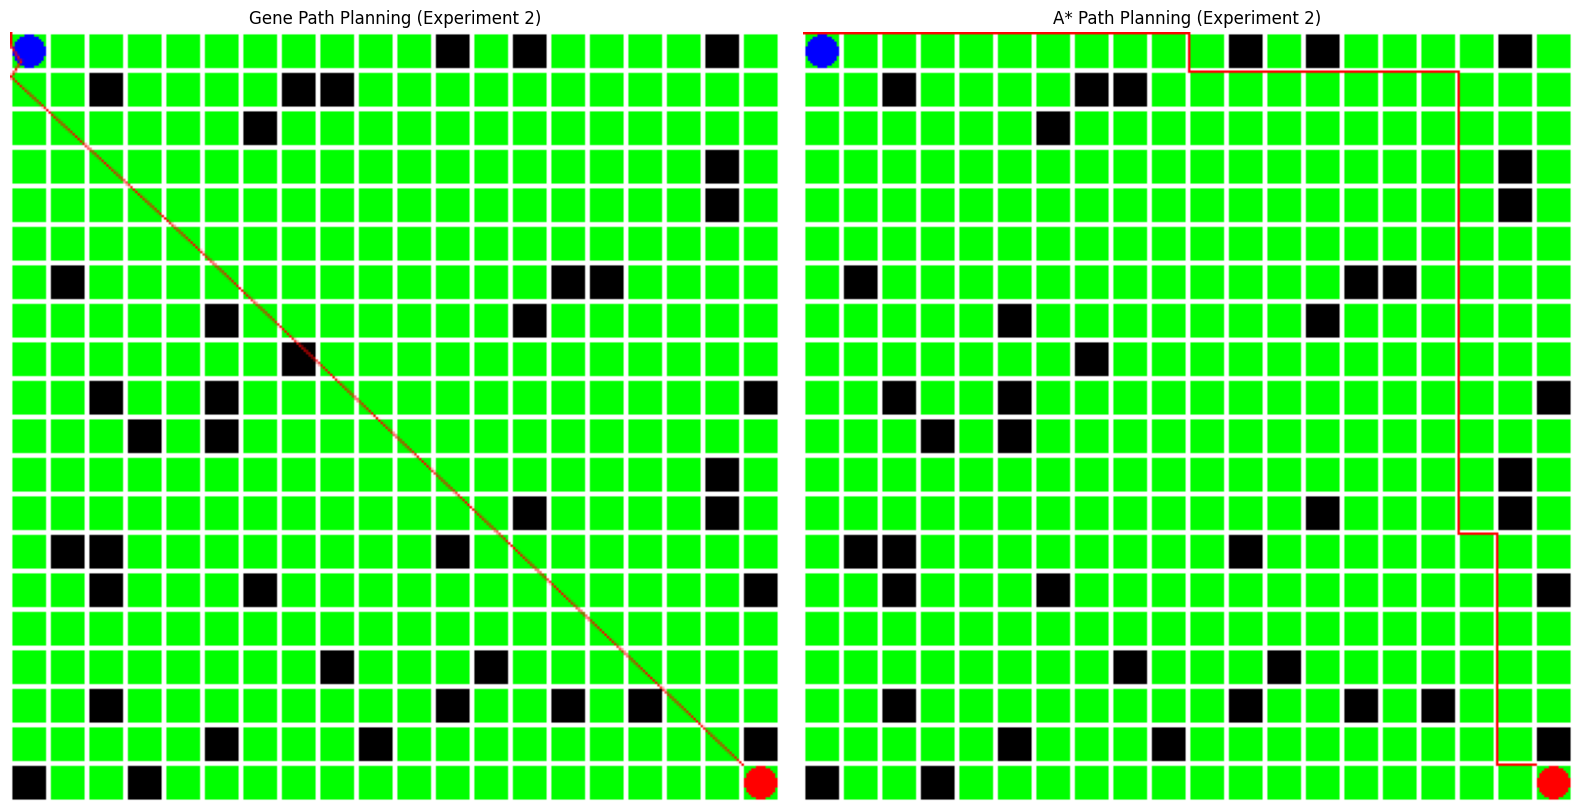


Experiment 3
Gene: Path found!
Gene path length: 9
A*: No valid path found!


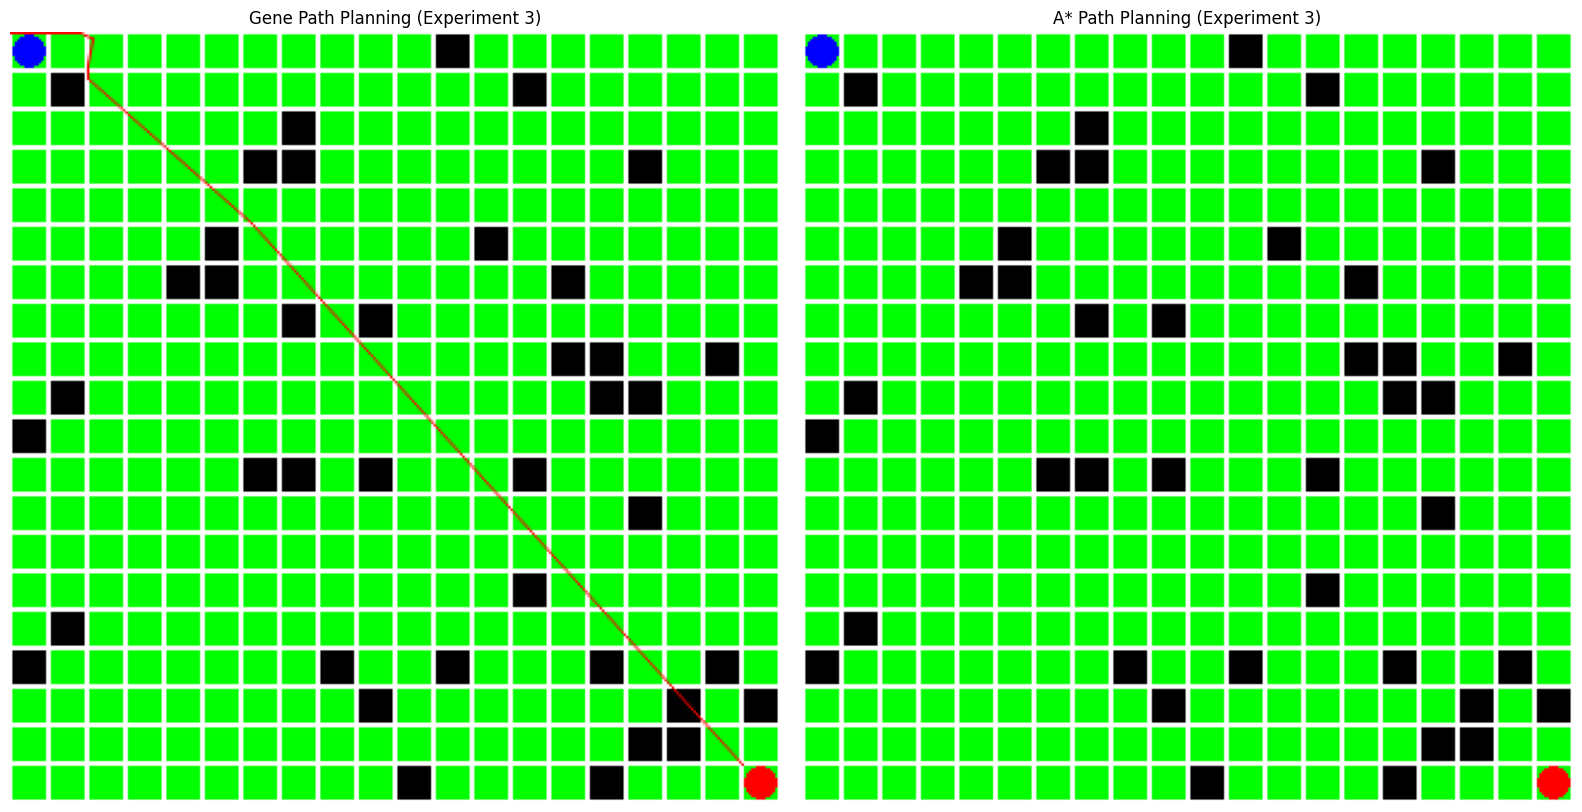


Experiment 4
Gene: Path found!
Gene path length: 28
A*: Path found!
A* path length: 39


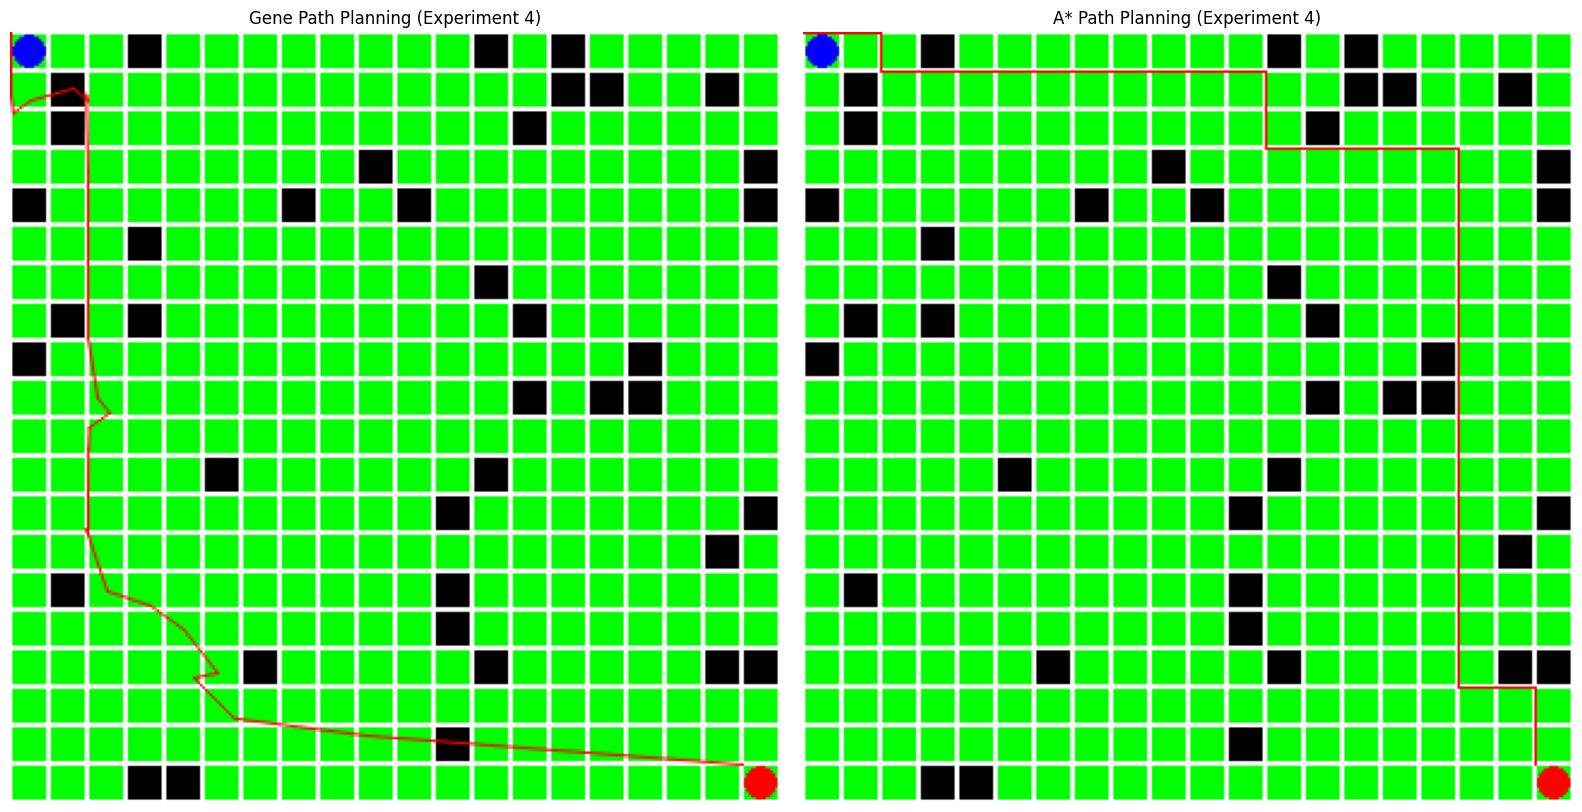


Experiment 5
Gene: Path found!
Gene path length: 34
A*: Path found!
A* path length: 39


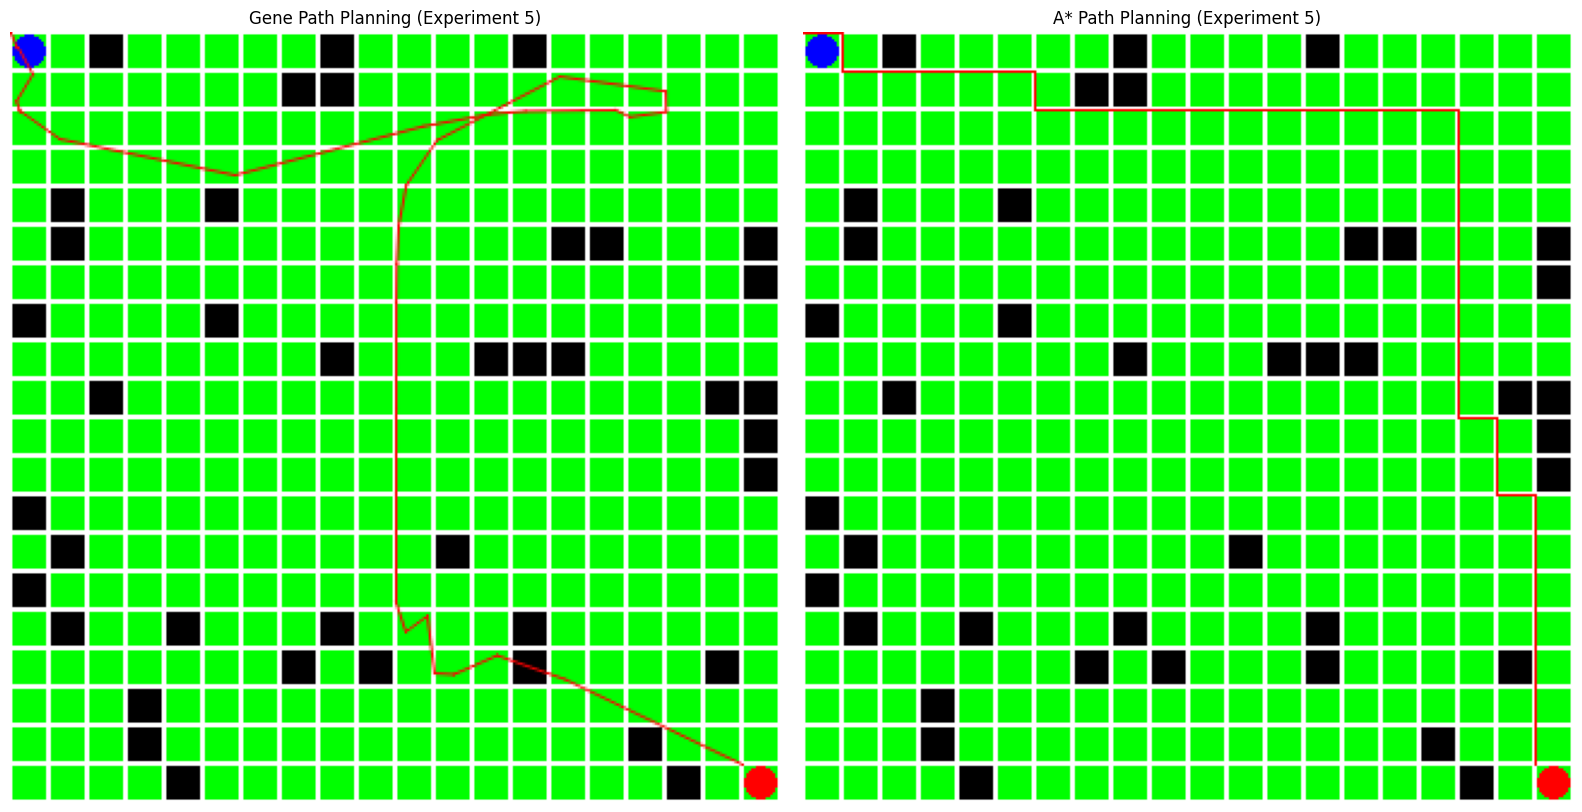

In [14]:
# 进行5次重复实验
for experiment_num in range(5):
    print(f"\nExperiment {experiment_num + 1}")
    
    # 随机生成70个障碍物
    obstacles = generate_random_obstacles(mapsize, 40, pos_snode, pos_enode)
    
    # 创建子图布局
    plt.figure(figsize=(16, 8))
    
    # 创建路径规划器
    planner = GeneticPathPlanner(map_size=mapsize, obstacles=obstacles)
    # 规划路径
    path, _ = planner.plan_path(pos_snode, pos_enode, isShowProcess=False)
    if path:
        print("Gene: Path found!")
        routelist_Gene = path
        print(f"Gene path length: {len(path)}")
    else:
        print("Gene: No valid path found!")
        routelist_Gene = []
    
    # 保存并显示DFS结果
    plt.subplot(1, 2, 1)
    saveResultImg(mapsize, pos_snode, pos_enode, obstacles, routelist_Gene)
    img_gene = skimage.io.imread('result0.png')
    plt.imshow(img_gene)
    plt.axis('off')
    plt.title(f'Gene Path Planning (Experiment {experiment_num + 1})')
    
    # A*算法路径规划
    path_astar = astar(pos_snode, pos_enode, obstacles)
    if path_astar:
        print("A*: Path found!")
        routelist_astar = path_astar
        print(f"A* path length: {len(path_astar)}")
    else:
        print("A*: No valid path found!")
        routelist_astar = []
    
    # 保存并显示A*结果
    plt.subplot(1, 2, 2)
    saveResultImg(mapsize, pos_snode, pos_enode, obstacles, routelist_astar)
    img_astar = skimage.io.imread('result0.png')
    plt.imshow(img_astar)
    plt.axis('off')
    plt.title(f'A* Path Planning (Experiment {experiment_num + 1})')
    
    plt.tight_layout()
    plt.show()

## 五、实验结果分析

双击此处添加你对本次实验结果的分析和思考。

## 六、扩展实验(选做)

扩展实验使用Coppeliasim进行移动机器人仿真。由于涉及到物理仿真，扩展实验不能在云端环境中运行，需要在本地电脑上安装CoppeliaSim软件，并运行实验脚本。实验中，使用了先锋Pioneer 3DX机器人作为实验对象，并随机放置了5个立方体障碍物，机器人的初始位置(-1.5, 1.5)，希望运动到的目标位置为(1.5, -1.5)，实验场景通过运行如下指令可以看到：


In [15]:
import os
_=os.system("start pioneer3dxSim.ttt")

结合机器人仿真环境，将A*算法实现为：

In [16]:
def genetic_search(start_pos, goal_pos, obstacles, grid_size=0.5):
    """
    使用遗传算法进行路径规划
    
    参数:
        start_pos: 起始位置坐标 (x, y, z)
        goal_pos: 目标位置坐标 (x, y, z)
        obstacles: 障碍物位置列表
        grid_size: 网格大小
        
    返回:
        path: 找到的路径列表，如果没找到则返回None
    """
    class GeneticPathPlanner:
        def __init__(self, population_size=100, generations=200):
            self.population_size = population_size
            self.generations = generations
            self.mutation_rate = 0.2
            self.x_range = (-2, 2)  # x坐标范围
            self.y_range = (-2, 2)  # y坐标范围
            
        def constrain_to_map(self, x, y, z):
            """确保坐标在地图范围内"""
            x = max(min(x, self.x_range[1]), self.x_range[0])
            y = max(min(y, self.y_range[1]), self.y_range[0])
            return (x, y, z)            
            
        def generate_path(self, start, goal, path_length):
            """生成一条随机路径"""
            path = [start]
            current = start
            for _ in range(path_length):
                # 在8个方向中随机选择一个
                directions = [(1,0), (-1,0), (0,1), (0,-1), 
                            (1,1), (-1,1), (1,-1), (-1,-1)]
                dx, dy = random.choice(directions)
                # 计算新位置并确保在地图范围内
                new_x = current[0] + dx * grid_size
                new_y = current[1] + dy * grid_size
                next_pos = self.constrain_to_map(new_x, new_y, current[2])
                path.append(next_pos)
                current = next_pos
            path.append(goal)
            return path
            
        def calculate_fitness(self, path, obstacles):
            """计算路径的适应度"""
            # 初始化惩罚项
            penalty = 0
            
            # 对超出地图范围的点添加惩罚
            for point in path:
                x, y = point[0], point[1]
                if not (self.x_range[0] <= x <= self.x_range[1] and 
                       self.y_range[0] <= y <= self.y_range[1]):
                    penalty += 2000
            
             # 计算路径长度
            length = sum(math.sqrt((path[i+1][0]-path[i][0])**2 + 
                                 (path[i+1][1]-path[i][1])**2)
                        for i in range(len(path)-1))

            # 计算路径长度和相邻点距离惩罚
            for i in range(len(path)-1):
                # 计算相邻点之间的距离
                dist = math.sqrt((path[i+1][0]-path[i][0])**2 + 
                               (path[i+1][1]-path[i][1])**2)
                # 如果距离大于grid_size，添加惩罚
                if dist > grid_size:
                    penalty += 800 * (dist - grid_size)
                
                x1, y1 = path[i][0], path[i][1]
                x2, y2 = path[i+1][0], path[i+1][1]
                
                # 计算路径段的方向角度
                if i > 0:
                    current_angle = math.atan2(y2 - y1, x2 - x1)
                    prev_x, prev_y = path[i-1][0], path[i-1][1]
                    prev_angle = math.atan2(y1 - prev_y, x1 - prev_x)
                    angle_diff = abs(current_angle - prev_angle)
                    if angle_diff > math.pi:
                        angle_diff = 2 * math.pi - angle_diff
                    penalty += 300 * angle_diff
                
                # 检查与障碍物的距离
                for obs in obstacles:
                    dist = min(math.sqrt((x-obs[0])**2 + (y-obs[1])**2)
                             for x, y in [(x1,y1), (x2,y2)])
                    if dist < grid_size:
                        penalty += 1000 * (grid_size - dist)
            
            return length + penalty
            
        def crossover(self, parent1, parent2):
            """执行交叉操作"""
            if len(parent1) != len(parent2):
                return parent1
            
            point = random.randint(1, len(parent1)-2)
            child = parent1[:point] + parent2[point:]
            return child
            
        def mutate(self, path):
            """执行变异操作"""
            if random.random() < self.mutation_rate:
                idx = random.randint(1, len(path)-2)
                directions = [(1,0), (-1,0), (0,1), (0,-1),
                            (1,1), (-1,1), (1,-1), (-1,-1)]
                dx, dy = random.choice(directions)
                new_x = path[idx][0] + dx * grid_size
                new_y = path[idx][1] + dy * grid_size
                path[idx] = self.constrain_to_map(new_x, new_y, path[idx][2])
            return path
    
    # 创建遗传算法规划器实例
    planner = GeneticPathPlanner()
    
    # 估计路径长度
    path_length = int(math.sqrt((goal_pos[0]-start_pos[0])**2 + 
                               (goal_pos[1]-start_pos[1])**2) / grid_size) * 6
    
    # 生成初始种群
    population = [planner.generate_path(start_pos, goal_pos, path_length) 
                 for _ in range(planner.population_size)]
    
    best_path = None
    best_fitness = float('inf')
    fitness_history = []  # <--- 新增：用于记录每一代的最佳适应度

    # 进行遗传算法迭代
    for generation in range(planner.generations):
        # 计算适应度
        fitness_scores = [planner.calculate_fitness(path, obstacles) 
                        for path in population]
        
        # 更新最优解
        min_fitness = min(fitness_scores)
        if min_fitness < best_fitness:
            best_fitness = min_fitness
            best_path = population[fitness_scores.index(min_fitness)]
        
        # 记录当前代的最优适应度
        fitness_history.append(min_fitness)

        # <--- 新增：每10次迭代输出提示信息 ---
        if (generation + 1) % 10 == 0:
            print(f"Generation {generation + 1}/{planner.generations}, Minimum Cost: {best_fitness:.4f}")

        # 选择操作
        selected = []
        for _ in range(planner.population_size):
            tournament = random.sample(list(enumerate(fitness_scores)), 3)
            winner = min(tournament, key=lambda x: x[1])[0]
            selected.append(population[winner])
        
        # 交叉和变异
        new_population = []
        for i in range(0, planner.population_size, 2):
            parent1 = selected[i]
            parent2 = selected[min(i+1, planner.population_size-1)]
            
            child1 = planner.crossover(parent1, parent2)
            child2 = planner.crossover(parent2, parent1)
            
            child1 = planner.mutate(child1)
            child2 = planner.mutate(child2)
            
            new_population.extend([child1, child2])
        
        population = new_population[:planner.population_size]
    
    # 如果找到了可行路径，进行路径平滑和点合并
    if best_path:
        # 路径平滑处理
        smoothed_path = [best_path[0]]  # 保留起点
        for i in range(1, len(best_path)-1):
            # 获取前中后三个点
            prev = smoothed_path[-1]
            current = best_path[i]
            next_point = best_path[i+1]
            
            # 计算平滑后的新位置（使用加权平均）
            smooth_x = 0.25 * prev[0] + 0.5 * current[0] + 0.25 * next_point[0]
            smooth_y = 0.25 * prev[1] + 0.5 * current[1] + 0.25 * next_point[1]
            
            # 确保平滑后的点在地图范围内
            smooth_pos = planner.constrain_to_map(smooth_x, smooth_y, current[2])
            smoothed_path.append(smooth_pos)
            
        smoothed_path.append(best_path[-1])  # 保留终点
        
        # 检测和删除回环以及距离过近的点
        while True:
            modified = False
            i = 0
            while i < len(smoothed_path)-2:  # -2是为了保护终点
                # 1. 检测回环
                for j in range(i+2, len(smoothed_path)-1):  # 至少间隔一个点才可能形成回环
                    # 计算两点间直接距离
                    direct_dist = math.sqrt(
                        (smoothed_path[j][0]-smoothed_path[i][0])**2 + 
                        (smoothed_path[j][1]-smoothed_path[i][1])**2
                    )
                    
                    # 计算路径距离
                    path_dist = sum(
                        math.sqrt(
                            (smoothed_path[k+1][0]-smoothed_path[k][0])**2 + 
                            (smoothed_path[k+1][1]-smoothed_path[k][1])**2
                        ) for k in range(i, j)
                    )
                    
                    # 如果路径距离远大于直接距离，说明存在回环
                    if path_dist > direct_dist * 1.5 and direct_dist < grid_size * 2:
                        # 删除回环上的点（保留第一个点）
                        del smoothed_path[i+1:j+1]
                        modified = True
                        break
                
                if modified:
                    break
                    
                # 2. 检测距离过近的点
                if i > 0:  # 不检查起点
                    current = smoothed_path[i]
                    next_point = smoothed_path[i+1]
                    dist = math.sqrt(
                        (next_point[0]-current[0])**2 + 
                        (next_point[1]-current[1])**2
                    )
                    
                    # 如果距离小于阈值，合并这两个点
                    if dist < grid_size * 0.5:
                        # 计算合并后的点（取中点）
                        merged_x = (current[0] + next_point[0]) / 2
                        merged_y = (current[1] + next_point[1]) / 2
                        merged_point = planner.constrain_to_map(
                            merged_x, merged_y, current[2]
                        )
                        smoothed_path[i] = merged_point
                        smoothed_path.pop(i+1)
                        modified = True
                        break
                
                i += 1
            
            # 如果没有任何修改，退出循环
            if not modified:
                break
        
        best_path = smoothed_path

    # <--- 新增：绘制适应度变化图 ---
    if best_path and fitness_history:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, planner.generations + 1), fitness_history) # X轴从1开始
        plt.xlabel("Generation")
        plt.ylabel("Minimum Cost Value")
        plt.title("Cost Evolution Over Generations")
        plt.grid(True)
        plt.show()

    return best_path if best_path else None

这时就可以开始进行机器人运动仿真了，运行下面代码前需要首先在CoppeliaSim中点击仿真开始按钮，然后再运行最后一段代码。如果没有找到合适的路径，可以多次运行最后一段代码，直到找到合适的路径。一旦最后一段代码运行起来了以后，可以转到CoppeliaSim中，观察机器人的运动过程。

![点击启动仿真按钮](开始仿真按钮.png)

Connected to CoppeliaSim
Generation 10/200, Minimum Cost: 19710.5115
Generation 20/200, Minimum Cost: 15912.6616
Generation 30/200, Minimum Cost: 12479.5776
Generation 40/200, Minimum Cost: 11606.3268
Generation 50/200, Minimum Cost: 11411.9968
Generation 60/200, Minimum Cost: 11379.0121
Generation 70/200, Minimum Cost: 11302.7387
Generation 80/200, Minimum Cost: 11197.1997
Generation 90/200, Minimum Cost: 11137.3461
Generation 100/200, Minimum Cost: 11137.3461
Generation 110/200, Minimum Cost: 10971.9536
Generation 120/200, Minimum Cost: 10334.3222
Generation 130/200, Minimum Cost: 10245.2030
Generation 140/200, Minimum Cost: 10245.2030
Generation 150/200, Minimum Cost: 10245.2030
Generation 160/200, Minimum Cost: 10245.2030
Generation 170/200, Minimum Cost: 10245.2030
Generation 180/200, Minimum Cost: 10245.2030
Generation 190/200, Minimum Cost: 10245.2030
Generation 200/200, Minimum Cost: 10245.2030


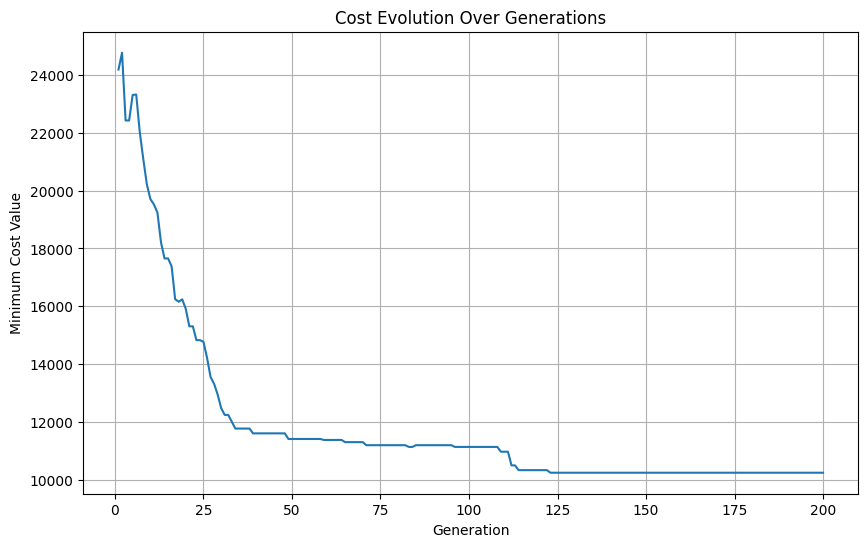

到达目标点，机器人已停止


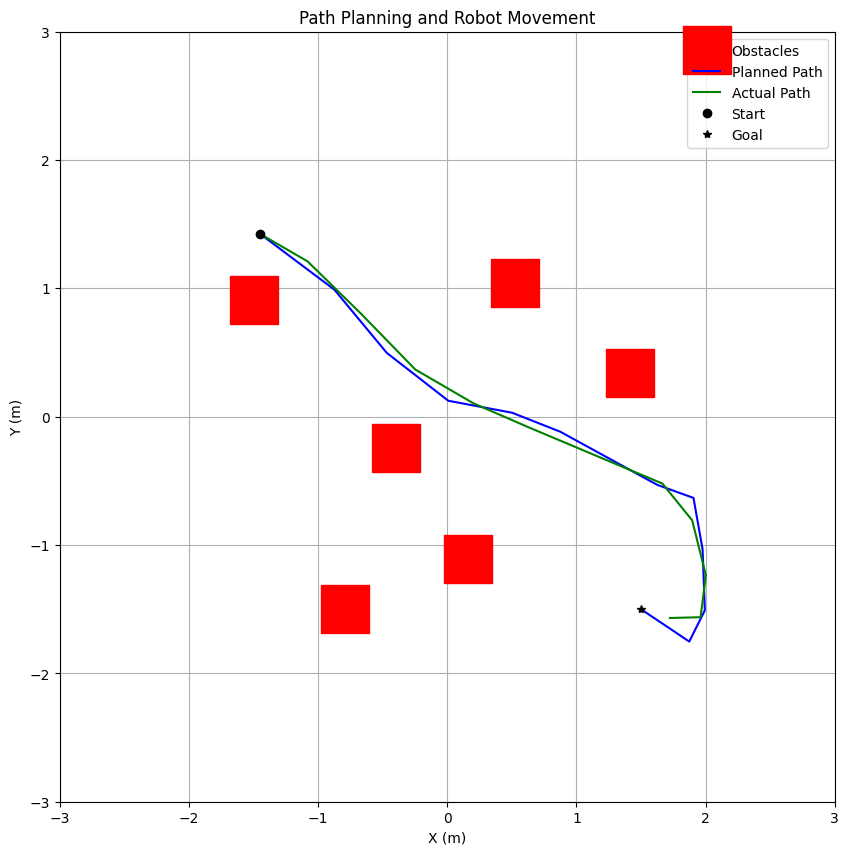

In [18]:
from pioneer_path_planning import runSimulation
runSimulation(search_func=genetic_search)